In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

In [3]:
print(train_data.shape)
print(test_data.shape)

(593994, 13)
(254569, 12)


In [4]:
train_data.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [5]:
train_data['loan_paid_back'].value_counts(normalize=True)
#imbalanced target varaibles

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [6]:
# mental rule 0 means safe and 1 means risk
# target meaning
# 1 means loan paid back(good) - Non defaulter
# 0 means loan not paid back(bad)    - Defaulter

# let's create new target column as defaulter and change labels in reverse so that 0 means non defaulter and 1 means defaulter
# it wil make lives easy as it will align how classification metrics work
# in binary classification metrics: positive class(1) should represent event of risk/problem/interest

In [7]:
train_data['default'] = (train_data['loan_paid_back']==0).astype(int)
# if current val is 0 in loan_paid_back column, it will become 1 and vice versa and we will remove the loan_paid back_column fro training set.

In [8]:
train_data.head(3)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,default
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,1
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,0


In [9]:
train_data=train_data.drop(columns=['loan_paid_back'])

In [10]:
train_data.isna().sum()
#No null values

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
default                 0
dtype: int64

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  default               593994 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 58.9+ MB


In [12]:
train_data.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
id,593994.0,296996.500000,171471.442235,0.000,5939.9300,29699.650,296996.500,564293.350,588053.070,593993.000
annual_income,593994.0,48212.202976,26711.942078,6002.430,10409.3300,15450.110,46557.680,93534.680,142246.850,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.0330,0.046,0.096,0.259,0.339,0.627
credit_score,593994.0,680.916009,55.424956,395.000,546.0000,582.000,682.000,767.000,811.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,1173.3186,3139.370,15000.220,27139.830,30281.190,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,7.6800,9.100,12.370,15.720,17.190,20.990
default,593994.0,0.201180,0.400883,0.000,0.0000,0.000,0.000,1.000,1.000,1.000


In [13]:
#handling outliers
# removing based on quantile or capping values to a limit or applying log transform so that to remove dominance of higher values.
# I will be applying Gradient Boosting models so removing outliers is not required most of the time as the model dont care about distance between values.

In [14]:
# scaling is not required for GB models as these are not distance based models so split happens based on threshols
# order matters not scale

In [15]:
# Encoding is required as model accepst numbers only
#Lightgbm can handle categorical values but they have to be dtype category, ths datset has object, need to change them to category.
# Also lets check if there are any grammer issues in categorical values - all seems fine

In [16]:
cat_cols = train_data.select_dtypes(include='object').columns
cat_cols

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

In [17]:
for col in cat_cols:
    train_data[col] = train_data[col].astype('category')

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    593994 non-null  int64   
 1   annual_income         593994 non-null  float64 
 2   debt_to_income_ratio  593994 non-null  float64 
 3   credit_score          593994 non-null  int64   
 4   loan_amount           593994 non-null  float64 
 5   interest_rate         593994 non-null  float64 
 6   gender                593994 non-null  category
 7   marital_status        593994 non-null  category
 8   education_level       593994 non-null  category
 9   employment_status     593994 non-null  category
 10  loan_purpose          593994 non-null  category
 11  grade_subgrade        593994 non-null  category
 12  default               593994 non-null  int64   
dtypes: category(6), float64(4), int64(3)
memory usage: 35.1 MB


In [19]:
train_data=train_data.drop(columns=['id'])

In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [21]:
y = train_data['default'].copy()
X = train_data.drop(columns=['default'])

In [22]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=42,stratify=y,test_size=0.2)

In [23]:
model = lgb.LGBMClassifier(n_estimators=1000,learning_rate=0.05,objective='binary',random_state=42)

In [24]:
model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric='auc',categorical_feature=list(cat_cols),callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=50)])

[LightGBM] [Info] Number of positive: 95600, number of negative: 379595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201181 -> initscore=-1.378932
[LightGBM] [Info] Start training from score -1.378932
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.916271	valid_0's binary_logloss: 0.259565
[100]	valid_0's auc: 0.918883	valid_0's binary_logloss: 0.249559
[150]	valid_0's auc: 0.92013	valid_0's binary_logloss: 0.24757
[200]	valid_0's auc: 0.92079	valid_0's binary_logloss: 0.246581
[250]	valid_0's auc: 0.921037	valid_0's binary_logloss: 0.246177
[300]	valid_0's auc: 0.921333	valid_0's binary_logloss: 0.

LGBMClassifier(learning_rate=0.05, n_estimators=1000, objective='binary',
               random_state=42)

In [25]:
# base line lightgbm is completed sboave.
# let's try to improve

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

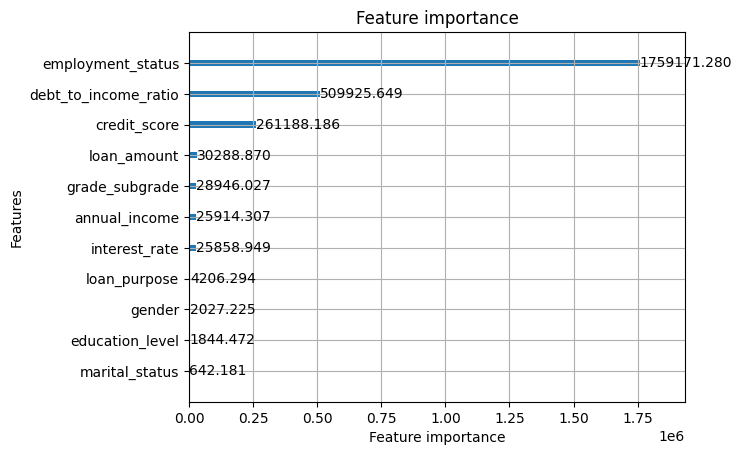

In [26]:
# step 1: feature importance
lgb.plot_importance(model,importance_type='gain',max_num_features=20)

In [27]:
#top 3 are employment status, debt to income ration and credit score.
# common in credit risk data but let's see if it is genuinely correct

In [28]:
pd.crosstab(train_data['employment_status'],train_data['default'],normalize='index')

default,0,1
employment_status,,
Employed,0.894145,0.105855
Retired,0.997204,0.002796
Self-employed,0.898457,0.101543
Student,0.263515,0.736485
Unemployed,0.077619,0.922381


In [29]:
train_data['employment_status'].value_counts(normalize=True)

employment_status
Employed         0.758669
Unemployed       0.105195
Self-employed    0.088351
Retired          0.027699
Student          0.020086
Name: proportion, dtype: float64

In [30]:
# feature importance seems to be fine, genuine
#let's add monotonic constraints.
# monotonic constraints tells model that when this feature increases, the prediction must only go up or down - never rever.
#we are enforcing business logic directly into the model.
#since employment status, DTI,credit score are our top 3 are are valid features.
# lets increase importance of DTI and credit risk and check, (employment status is already driving good)
# this is to make sure that model wont learn from wierd features that if DTI is high, then credit risk is low - or credit score is high, credit risk is high which is not true in real world.
# so we enforce the importance.

In [31]:
monotone_constraints = [0]*X.shape[1]
monotone_constraints

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [32]:
dti_idx = X.columns.get_loc('debt_to_income_ratio')
credit_idx = X.columns.get_loc('credit_score')
monotone_constraints[dti_idx]=1
# higher DTI  - higher risk
monotone_constraints[credit_idx]=-1
# higher credit score - lower risk

In [33]:
model_mc = lgb.LGBMClassifier(n_estimators=500,learning_rate=0.05,objective='binary',monotone_constraints=monotone_constraints,random_state=42)

In [34]:
model_mc.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric='auc',categorical_feature=list(cat_cols),callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=50)])

[LightGBM] [Info] Number of positive: 95600, number of negative: 379595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201181 -> initscore=-1.378932
[LightGBM] [Info] Start training from score -1.378932
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.913309	valid_0's binary_logloss: 0.263073
[100]	valid_0's auc: 0.916031	valid_0's binary_logloss: 0.253111
[150]	valid_0's auc: 0.916488	valid_0's binary_logloss: 0.252057
[200]	valid_0's auc: 0.916636	valid_0's binary_logloss: 0.251781
[250]	valid_0's auc: 0.91661	valid_0's binary_logloss: 0.251785
Early stopping, best iteration is:
[230]	valid_0's auc: 

LGBMClassifier(learning_rate=0.05,
               monotone_constraints=[0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
               n_estimators=500, objective='binary', random_state=42)

In [35]:
# after adding monotonic constraints the auc decresed a lot - but the business logic is correct in real scenario.
# DTI / credit score might be noisy or
# DTI behaves differentlyby employment status
# credit score behaves differently by  income band
# our baseline model might be partially overfitting
# some AUC gain was coming from data specific quirks and our constraints removed that lucky signal.

# let's try with credit score only and remove DTI from constraints

In [36]:
monotone_constraints[dti_idx]=0

In [37]:
monotone_constraints

[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
model_mcs = lgb.LGBMClassifier(n_estimators=1000,learning_rate=0.05,objective='binary',monotone_constraints=monotone_constraints,random_state=42)

In [39]:
model_mcs.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric='auc',categorical_feature=list(cat_cols),callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=50)])

[LightGBM] [Info] Number of positive: 95600, number of negative: 379595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201181 -> initscore=-1.378932
[LightGBM] [Info] Start training from score -1.378932
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.915405	valid_0's binary_logloss: 0.260363
[100]	valid_0's auc: 0.918603	valid_0's binary_logloss: 0.249727
[150]	valid_0's auc: 0.91992	valid_0's binary_logloss: 0.247738
[200]	valid_0's auc: 0.920708	valid_0's binary_logloss: 0.246614
[250]	valid_0's auc: 0.920994	valid_0's binary_logloss: 0.246202
[300]	valid_0's auc: 0.921342	valid_0's binary_logloss: 

LGBMClassifier(learning_rate=0.05,
               monotone_constraints=[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
               n_estimators=1000, objective='binary', random_state=42)

In [40]:
# found sweet spot - minimal performance loss for a stable / hugh gain in model correctness
# traded tiny bit of AUC for logical behaviour,stability,prod acceptance

In [41]:
# let's do corss validation to check if the AUC is stable or lucky on one split

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

X_cv = X.copy()
y_cv = y.copy()

skf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=42)
auc_scores = []

In [43]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    X_train_f, X_val_f = X_cv.iloc[train_idx], X_cv.iloc[val_idx]
    y_train_f, y_val_f = y_cv.iloc[train_idx], y_cv.iloc[val_idx]
    print(type(X_train_f),type(y_train_f))
    print(type(X_val_f),type(y_val_f))
 
    model_cv = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        objective="binary",
        monotone_constraints=monotone_constraints,
        random_state=42
    )
    model_cv.fit(
        X_train_f,
        y_train_f,
        eval_set=[(X_val_f, y_val_f)],
        eval_metric="auc",
        categorical_feature=list(cat_cols),
        callbacks=[lgb.early_stopping(stopping_rounds=50),lgb.log_evaluation(period=50)])
    
    preds = model_cv.predict_proba(X_val_f)[:, 1]
    auc = roc_auc_score(y_val_f, preds)
    
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
[LightGBM] [Info] Number of positive: 95600, number of negative: 379595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.201181 -> initscore=-1.378932
[LightGBM] [Info] Start training from score -1.378932
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.915346	valid_0's binary_logloss: 0.260739
[100]	valid_0's auc: 0.918602	valid_0's binary_logloss: 0.250184
[150]	valid_0's auc: 0.919872	valid_0's binary_logloss: 0.248164
[200]	valid_0's auc: 0.920436	valid_0

In [44]:
print("\nMean AUC:", np.mean(auc_scores))
print("Std AUC:", np.std(auc_scores))


Mean AUC: 0.9210949327237069
Std AUC: 0.0006960117233358016


In [45]:
# got good auc scores for all splits and the mean/std seems to be great
# more stable across all splits

In [46]:
# let's work on threshold cut off - reject top 15 percent risky customers
# we are not rejecting scores below a cut off point because as data changes, there is a chance a lot of customers might fall below the cutoff which is bad for business.
# so we are going with fixed percent customers which is better for business.

In [47]:

y_true = y_val
y_prob = model_mcs.predict_proba(X_val)[:,1]
threshold = np.quantile(y_prob,0.85)

In [48]:
threshold
# our threshold is default - users who are having prob score high or equal than this value should be rejected

np.float64(0.45420613901298873)

In [49]:
y_reject = (y_prob>=threshold).astype(int)
y_reject
# if val is 0, means they can be approved and if is 1, they should be rejected

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
# mental rule 0 means safe and 1 means risk
# target meaning
# 0 means (good) - Non defaulter
# 1 means (bad)    - Defaulter
#0 means approved
# 1 means rejected

In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_reject)
cm

array([[92381,  2518],
       [ 8598, 15302]])

In [52]:
# confusiojn matrix return as below
# TN      FP
# FN      TP

In [53]:
# actual/decision   Approved(0)    Rejected(1)
# Actual Good(0)         94611        288
# Actual Bad(1)         12308        11592

In [54]:
# Key business interpretation
# Good things
# You rejected 11592 bad customers
# You approved 94611 good customers
#  Costly things
# You still approved 12308 bad customers (loss)
# You rejected 288 good customers (opportunity loss)

In [55]:
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
# TN,FP,FN,TP = cm.ravel()

In [56]:
print(TN,FP,FN,TP)

92381 2518 8598 15302


In [57]:
# Recall - TP/TP+FN - bad customers caught out of all true bad customers

recall =TP / (TP+FN)
recall

np.float64(0.6402510460251046)

In [58]:
# accuracy - predicted correct out of all predicted values - bad rejected and good approved out of all predcited
accuracy = (TP+TN)/(TP+TN+FP+FN)
accuracy

np.float64(0.9064301888063031)

In [59]:
# Precision - rejection quality - bad customer caught out of all predicted bad customers
precision = TP / (TP+FP)
precision

np.float64(0.8586980920314253)

In [60]:
# Specificity - good customers approved
specificity = TN/(TN+FP)
specificity

np.float64(0.973466527571418)

In [61]:
# got good precision and specificity
# average recall
# let's compare rejection rates by use 5,10, 15 and 20 rates.

In [62]:

def evaluate_reject_rate(y_true, y_prob, reject_rate):
    # threshold from quantile
    threshold = np.quantile(y_prob, 1 - reject_rate)
 
    # decision
    y_pred = (y_prob >= threshold).astype(int)
 
    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
 
    # metrics
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
 
    return {
        "reject_rate": reject_rate,
        "threshold": threshold,
        "recall": recall,
        "precision": precision,
        "specificity": specificity,
        "TN": TN, "FP": FP, "FN": FN, "TP": TP
    }

In [63]:
results = []
 
for r in [0.05, 0.10,0.15, 0.20]:
    res = evaluate_reject_rate(y_true, y_prob, r)
    results.append(res)
 
results

[{'reject_rate': 0.05,
  'threshold': np.float64(0.985760490799944),
  'recall': np.float64(0.24728033472803349),
  'precision': np.float64(0.9949494949494949),
  'specificity': np.float64(0.9996838744349256),
  'TN': np.int64(94869),
  'FP': np.int64(30),
  'FN': np.int64(17990),
  'TP': np.int64(5910)},
 {'reject_rate': 0.1,
  'threshold': np.float64(0.8611952708072396),
  'recall': np.float64(0.48502092050209206),
  'precision': np.float64(0.9757575757575757),
  'specificity': np.float64(0.9969651945752853),
  'TN': np.int64(94611),
  'FP': np.int64(288),
  'FN': np.int64(12308),
  'TP': np.int64(11592)},
 {'reject_rate': 0.15,
  'threshold': np.float64(0.45420613901298873),
  'recall': np.float64(0.6402510460251046),
  'precision': np.float64(0.8586980920314253),
  'specificity': np.float64(0.973466527571418),
  'TN': np.int64(92381),
  'FP': np.int64(2518),
  'FN': np.int64(8598),
  'TP': np.int64(15302)},
 {'reject_rate': 0.2,
  'threshold': np.float64(0.28957946672727247),
  're

In [64]:
# seems to be 15 percent reject rate is good for this as recall is 64 which means we have 36 percent defaulters went approved much better than 10 reject rate where 52 percent went through
# acceptable precision is at 86 percent and specificity at 97 - business friendly

In [65]:
# let's freeze the threshold at 15 percent else, the metrics will keep changing which is not acceptable
# let's do everything based on this 15 percent rate threshold
# threshold is 0.4542

In [66]:
# # final decision rule
# if pd_probability>=0.4542:
#     decision="REJECT"
# else:
#     decision  = "APPROVE"

In [67]:
# KS Statistic (industry standard validation)
# How well the model sepertae BAD and GOOD Customers

In [68]:
df_ks = pd.DataFrame({
    "y_true": y_true,      # 1 = BAD, 0 = GOOD
    "y_prob": y_prob       # P(default)
})
 
# Create deciles (or 10 score bands)
df_ks["decile"] = pd.qcut(df_ks["y_prob"], 10, labels=False)
 
ks_table = (
    df_ks
    .groupby("decile")
    .agg(
        bads=("y_true", "sum"),
        total=("y_true", "count")
    )
    .sort_index(ascending=False)
)
 
ks_table["goods"] = ks_table["total"] - ks_table["bads"]
ks_table["cum_bad_pct"] = ks_table["bads"].cumsum() / ks_table["bads"].sum()
ks_table["cum_good_pct"] = ks_table["goods"].cumsum() / ks_table["goods"].sum()
ks_table["ks"] = np.abs(ks_table["cum_bad_pct"] - ks_table["cum_good_pct"])
 
ks_value = ks_table["ks"].max()
ks_value

0.6711228541985245

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

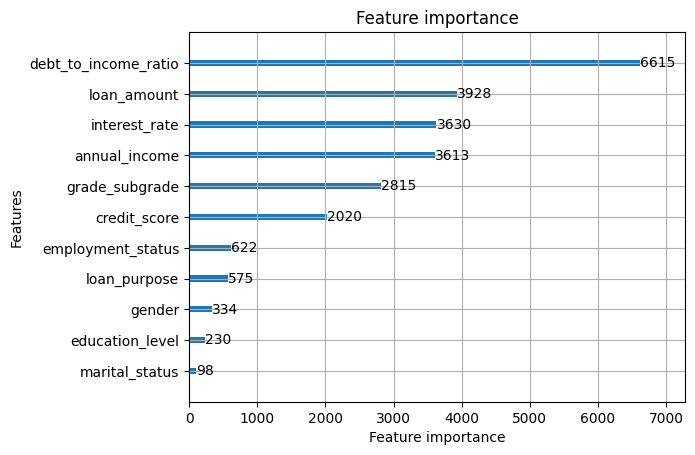

In [69]:
# Global Explainability
lgb.plot_importance(model_mcs,max_num_features=15)

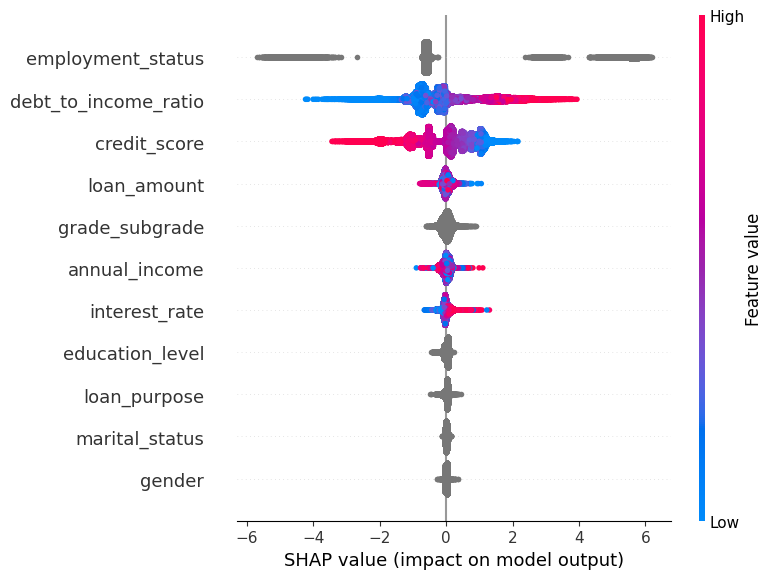

In [70]:
import shap
explainer = shap.TreeExplainer(model_mcs)
shap_values = explainer(X_val)
shap.summary_plot(shap_values,X_val)
# red mean high risk, blue means low risk applies for numerical featues where black means categorical features.
# top to bottom, the feature importance decreses on how they contribute in predicitng the output

In [71]:
# red on right side and blue on left for DTI indicates as DTI increaes, the risk increases
# red on left and blue on right for credit_score indicates as credit_score increases risk becomes low and vice versa
# black is for categorical features

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


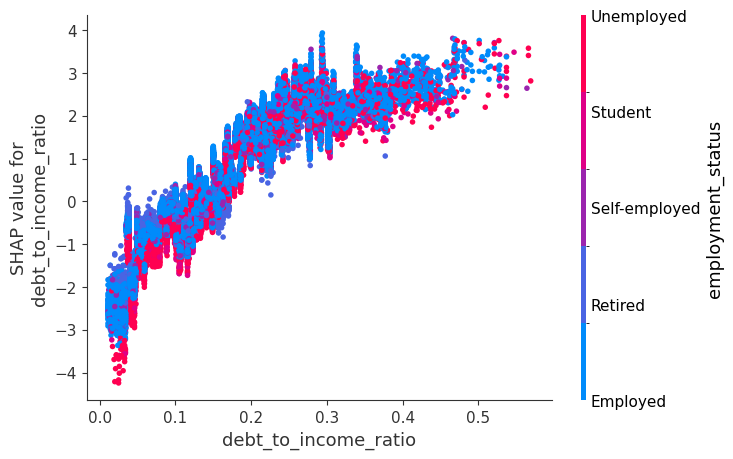

In [72]:
shap_values_d = explainer.shap_values(X_val)
shap.dependence_plot('debt_to_income_ratio',shap_values_d,X_val)

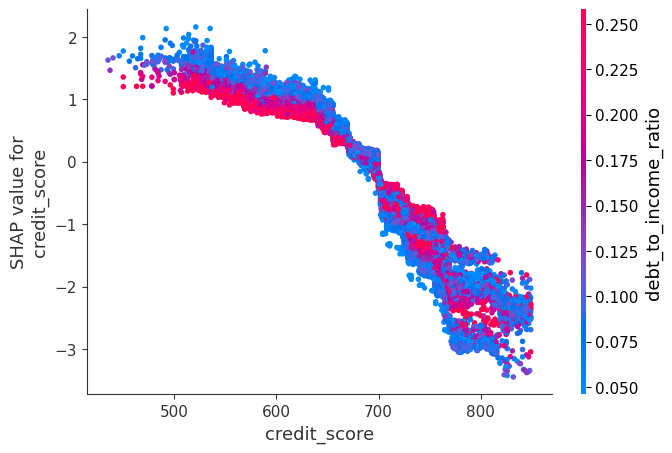

In [73]:
shap.dependence_plot('credit_score',shap_values_d,X_val)

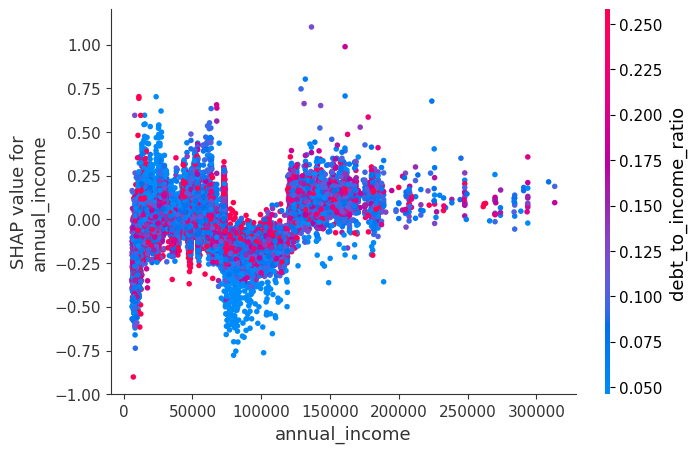

In [74]:
shap.dependence_plot('annual_income',shap_values_d,X_val)

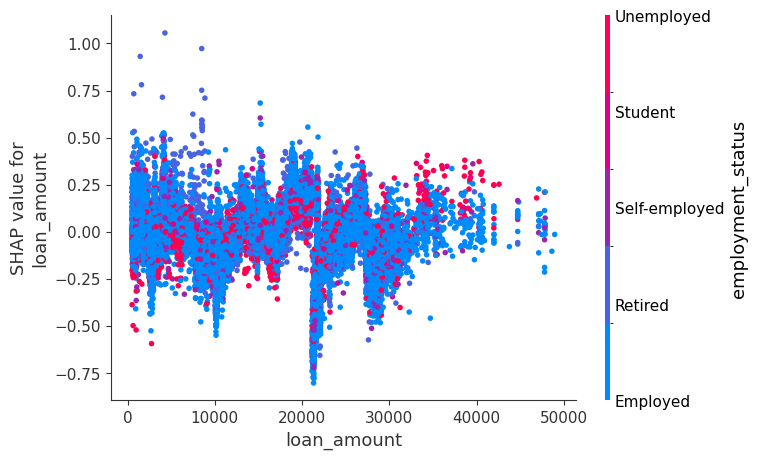

In [75]:
shap.dependence_plot('loan_amount',shap_values_d,X_val)

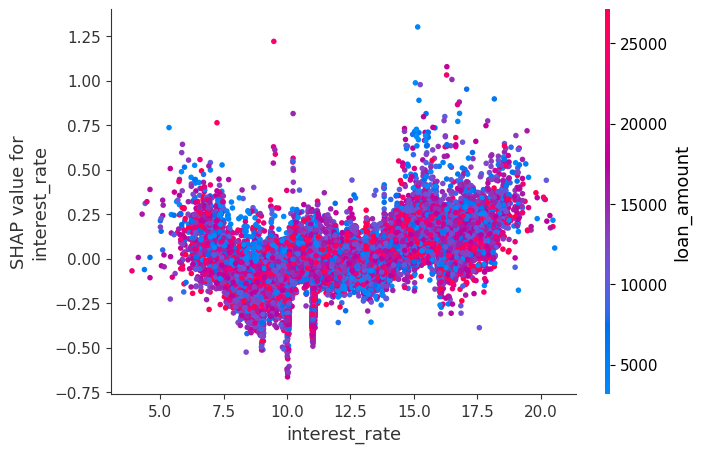

In [76]:
shap.dependence_plot('interest_rate',shap_values_d,X_val)

In [77]:
# Dependence plot
# as if shap increaees as value increases means risk increases as value increases like in DTI
# if shap decreses as value decreases means risk decreses as value increases like in Credit_score

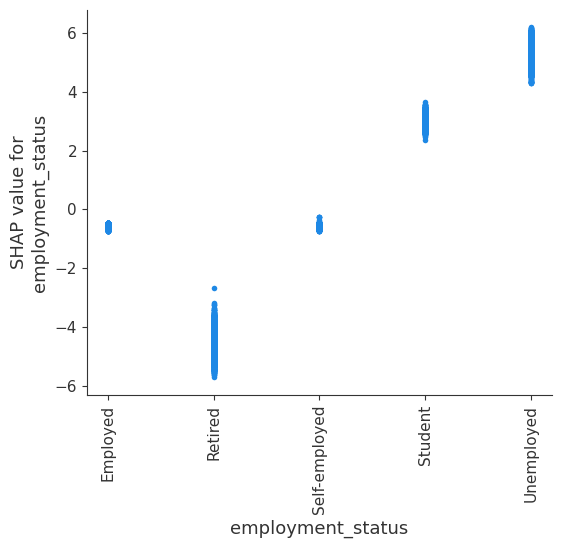

In [78]:
# Let's do depence plot for categorical feature
shap.dependence_plot('employment_status',shap_values_d,X_val,interaction_index=None)

In [79]:
# shap value below 0 for employed,retired and self employed
# shap is greater then 0 for student and more for unemployed
# shap value increases as risk increases - seems to be fins as expected.

In [80]:
# let's explain 1 customer why they got rejected.
rejected_idx = np.where(y_reject==1)[0]
i = rejected_idx[0]
i

np.int64(13)

In [81]:
X_val.iloc[i]

annual_income             27129.04
debt_to_income_ratio         0.092
credit_score                   698
loan_amount               17058.16
interest_rate                11.42
gender                        Male
marital_status              Single
education_level         Bachelor's
employment_status       Unemployed
loan_purpose                   Car
grade_subgrade                  C3
Name: 162266, dtype: object

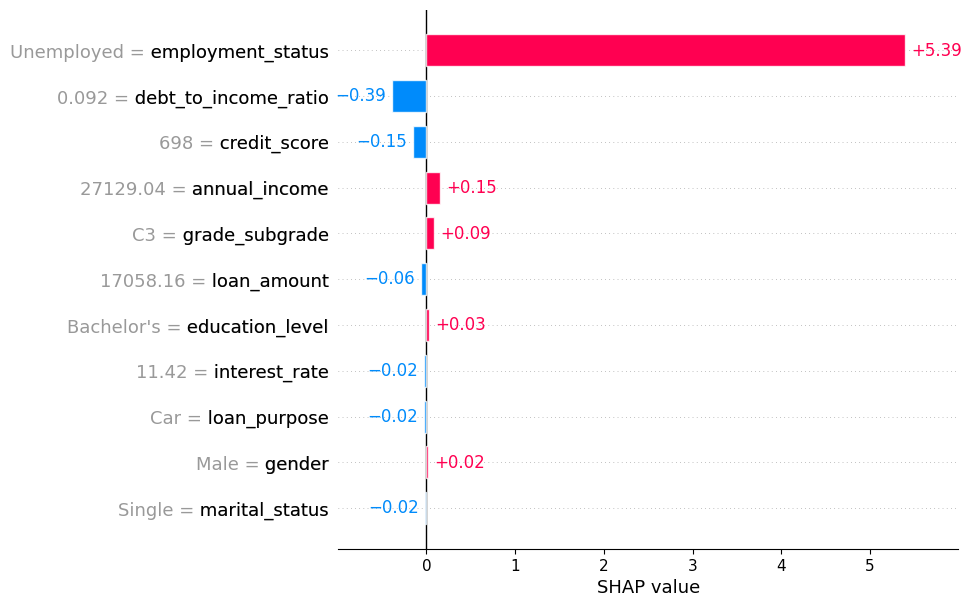

In [82]:
# generate shap for this customer
shap.plots.bar(shap_values[i],max_display=11)

In [83]:
# let's explain 1 customer why they got approved.
approved_idx = np.where(y_reject==0)[0]
j = approved_idx[0]
j

np.int64(0)

In [84]:
X_val.iloc[j]

annual_income              63626.58
debt_to_income_ratio          0.091
credit_score                    709
loan_amount                 4268.27
interest_rate                 10.23
gender                         Male
marital_status             Divorced
education_level         High School
employment_status          Employed
loan_purpose               Business
grade_subgrade                   C2
Name: 489413, dtype: object

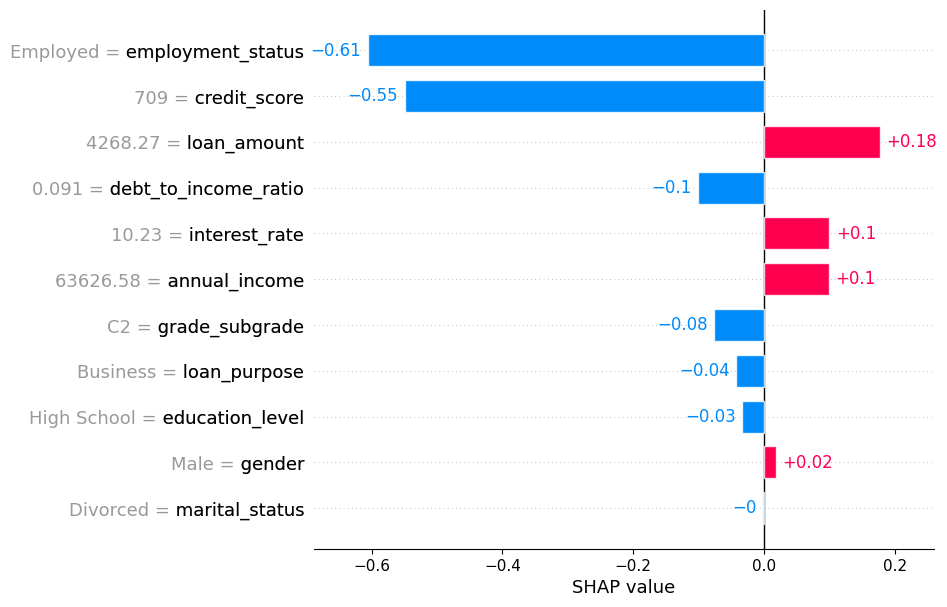

In [85]:
# generate shap for this customer
shap.plots.bar(shap_values[j],max_display=11)

In [86]:
# Strong model
# Stable validation
# Frozen business policy
# Defensible threshold
# KS validation
# Portfolio explainability
# Individual explainability